Previous dataset size: 597
Test Accuracy: 2.50%


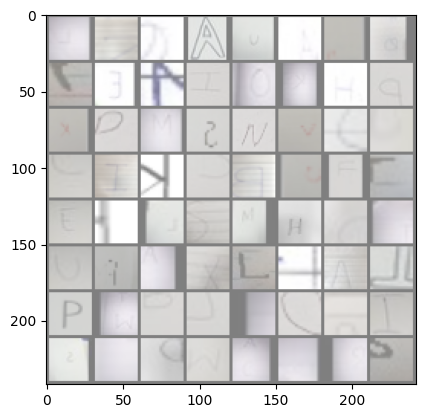

GroundTruth: L Z Q A U A R Q Y E N I O K H P K P M S N V S J C I K C B U F T E P L S M H D T U F A X L F A I P W B L K D A I S T D W A Q R S
Predicted: M _ a M _ _ M M Z M b _ Z M _ _ M _ M a a _ _ _ _ a a _ a _ M Z _ a a _ M a _ _ _ a M a Z M _ M a Z _ _ Z a _ _ M _ _ _ M M Z Z


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.nn.functional as F
from torch import nn, optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from PIL import Image
import pandas as pd
import os
import numpy as np
import torchvision  # Added import

# Assuming the A-Z dataset is organized in folders named 'A', 'B', ..., 'Z'
data_path = "/content/drive/MyDrive/Main"
csv_file = "/content/drive/MyDrive/Main/output.csv"

# Step 1: Create a custom dataset class
class CustomDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):  # Corrected initialization method name
        self.data = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):  # Corrected method name
        return len(self.data)

    def __getitem__(self, idx):  # Corrected method name
        img_name = os.path.join(self.root_dir, self.data.iloc[idx, 0])
        image = Image.open(img_name).convert('RGB')  # Convert RGBA to RGB
        label = ord(self.data.iloc[idx, 1]) - ord('A')  # Convert label to integer (0-25)

        if self.transform:
            image = self.transform(image)

        return image, label

# Step 2: Apply data augmentation
transform = transforms.Compose([
    transforms.RandomResizedCrop(28),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

# Step 3: Create DataLoader
dataset = CustomDataset(csv_file=csv_file, root_dir=data_path, transform=transform)

# Step 4: Print previous and current size of the dataset
print(f"Previous dataset size: {len(dataset)}")

# Step 5: Split the dataset into train and test
train_size = 0.8
train_dataset, test_dataset = train_test_split(dataset, train_size=train_size, shuffle=True)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)  # Corrected shuffle parameter

# Step 6: Define CNN model
class CNNModel(nn.Module):
    def __init__(self):  # Corrected initialization method name
        super(CNNModel, self).__init__()  # Corrected method name
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(32 * 7 * 7, 256)
        self.fc2 = nn.Linear(256, 26)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Instantiate the model and define optimizer and loss function
model = CNNModel()
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Step 7: Train the model
num_epochs = 10
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        if (i+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

# Step 8: Evaluate the model
model.eval()
all_predictions = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_predictions.extend(predicted.tolist())
        all_labels.extend(labels.tolist())

# Step 9: Calculate accuracy
accuracy = accuracy_score(all_labels, all_predictions)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

# ... (previous code)

# Step 10: Visualize images and predictions
import matplotlib.pyplot as plt

def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Iterate through the test loader
for images, labels in test_loader:
    # Print images
    imshow(torchvision.utils.make_grid(images))
    print('GroundTruth:', ' '.join([chr(ord('A') + label) for label in labels]))

    # Print predicted labels
    model.eval()
    with torch.no_grad():
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        print('Predicted:', ' '.join([chr(ord('L') + label) for label in predicted]))

    # Break after the first iteration if you just want to visualize a subset
    break
